In [6]:
import time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms

In [ ]:
# operaciones convolucionales de cuda
# if torch.cuda.is_available():
#     torch.backends.cudnn.deterministic = True

In [7]:
##########################
### SETTINGS
##########################

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device:', device)

# Hyperparameters
random_seed = 0
learning_rate = 0.001
num_epochs = 50
batch_size = 128

# Architecture
num_classes = 10
num_features = 784
num_hidden_1 = 500
# num_hidden_1 = 512
# num_latent = 35
num_latent = 8


##########################
### MNIST DATASET
##########################

# Note transforms.ToTensor() scales input images
# to 0-1 range
# train_dataset = datasets.MNIST(root='data',
#                                train=True,
#                                transform=transforms.ToTensor(),
#                                download=True)

# test_dataset = datasets.MNIST(root='data',
#                               train=False,
#                               transform=transforms.ToTensor())


# train_loader = DataLoader(dataset=train_dataset,
#                           batch_size=batch_size,
#                           shuffle=True) # shuffle barajar

# test_loader = DataLoader(dataset=test_dataset,
#                          batch_size=batch_size,
#                          shuffle=False)

data = DataLoader(
        datasets.MNIST(
              root = 'data',
              transform = transforms.ToTensor(),
              download=True
            ),
        batch_size = batch_size,
        shuffle = False
      )

# Checking the dataset
for images, labels in data:
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    print(len(data.dataset))
    break

Device: cuda:0
Image batch dimensions: torch.Size([128, 1, 28, 28])
Image label dimensions: torch.Size([128])
60000


In [8]:
##########################
### MODEL
##########################


def to_onehot(labels, num_classes, device):
    # binariza las etiquetas, es decir convierte las etiquetas de clase en columnas y por fila, asigna un 1 en la columna que cumpla con la etiqueta
    labels_onehot = torch.zeros(labels.size()[0], num_classes).to(device.type)
    labels_onehot.scatter_(1, labels.view(-1, 1), 1)
    return labels_onehot


class ConditionalVariationalAutoencoder(torch.nn.Module):

    def __init__(self, num_features, num_hidden_1, num_latent, num_classes):
        super(ConditionalVariationalAutoencoder, self).__init__()

        # self.[...]: define variables de clase
        self.num_classes = num_classes

        ### ENCODER
        self.hidden_1 = nn.Linear(num_features+num_classes, num_hidden_1)
        self.z_mean = nn.Linear(num_hidden_1, num_latent)
        # in the original paper (Kingma & Welling 2015, we use
        # have a z_mean and z_var, but the problem is that
        # the z_var can be negative, which would cause issues
        # in the log later. Hence we assume that latent vector
        # has a z_mean and z_log_var component, and when we need
        # the regular variance or std_dev, we simply use
        # an exponential function
        self.z_log_var = nn.Linear(num_hidden_1, num_latent)

        ### DECODER
        self.linear_3 = nn.Linear(num_latent+num_classes, num_hidden_1)
        self.linear_4 = nn.Linear(num_hidden_1, num_features+num_classes)

    def reparameterize(self, z_mu, z_log_var):
        # Sample epsilon from standard normal distribution
        eps = torch.randn(z_mu.size(0), z_mu.size(1)).to(device.type)
        # note that log(x^2) = 2*log(x); hence divide by 2 to get std_dev
        # i.e., std_dev = exp(log(std_dev^2)/2) = exp(log(var)/2)
        z = z_mu + eps * torch.exp(z_log_var/2.) ## debería quitarse "/2"
        return z

    def encoder(self, features, targets):
        ### Add condition
        onehot_targets = to_onehot(targets, self.num_classes, device)
        x = torch.cat((features, onehot_targets), dim=1)

        ### ENCODER
        x = self.hidden_1(x)
        x = F.leaky_relu(x)
        z_mean = self.z_mean(x)
        z_log_var = self.z_log_var(x)

        # encoded: espacio latente
        encoded = self.reparameterize(z_mean, z_log_var)
        return z_mean, z_log_var, encoded

    def decoder(self, encoded, targets):
        ### Add condition
        onehot_targets = to_onehot(targets, self.num_classes, device)
        encoded = torch.cat((encoded, onehot_targets), dim=1)

        ### DECODER #forward
        x = self.linear_3(encoded)
        x = F.leaky_relu(x)
        x = self.linear_4(x)
        decoded = torch.sigmoid(x)
        return decoded

    def forward(self, features, targets):

        z_mean, z_log_var, encoded = self.encoder(features, targets)
        decoded = self.decoder(encoded, targets)

        return z_mean, z_log_var, encoded, decoded


torch.manual_seed(random_seed) # garantizar repetibilidad
model = ConditionalVariationalAutoencoder(num_features,
                                          num_hidden_1,
                                          num_latent,
                                          num_classes)
# model = model.to(device)
model = model.to(device.type)




In [ ]:
device.type

'cuda'

In [ ]:
features.shape

torch.Size([96, 784])

In [ ]:
targets.shape

torch.Size([96])

In [ ]:
##########################
### TRAINING
##########################
def train(model, data, num_epochs=20):
  ##########################
  ### COST AND OPTIMIZER
  ##########################

  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  start_time = time.time()
  for epoch in range(num_epochs):
    # for batch_idx, (features, targets) in enumerate(train_loader):
    for batch_idx, (features, targets) in enumerate(data):

      features = features.view(-1, 28*28).to(device.type)
      targets = targets.to(device.type)

      ### FORWARD AND BACK PROP
      optimizer.zero_grad()
      z_mean, z_log_var, encoded, decoded = model(features, targets)

      # cost = reconstruction loss + Kullback-Leibler divergence
      kl_divergence = (0.5 * (z_mean**2 +
                              torch.exp(z_log_var) - z_log_var - 1)).sum()

      # add condition
      x_con = torch.cat((features, to_onehot(targets, num_classes, device)), dim=1)

      pixelwise_bce = F.binary_cross_entropy(decoded, x_con, reduction='sum')
      cost = kl_divergence + pixelwise_bce

      cost.backward()

      ### UPDATE MODEL PARAMETERS
      optimizer.step()

      ### LOGGING
      if not batch_idx % 50:
          print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f'
                #  %(epoch+1, num_epochs, batch_idx, len(train_loader)//batch_size, cost))
                  %(epoch+1, num_epochs, batch_idx, len(data)//batch_size, cost))

    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

  print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))
  return model

In [ ]:
trained_cvae = train(model, data, num_epochs)

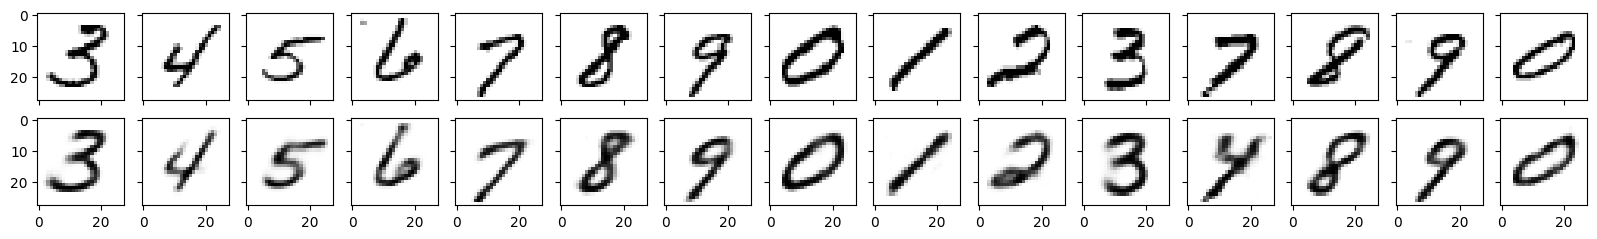

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

##########################
### VISUALIZATION
##########################

n_images = 15
image_width = 28

fig, axes = plt.subplots(nrows=2, ncols=n_images,
                         sharex=True, sharey=True, figsize=(20, 2.5))


batch_idx, (features, targets) = data.__iter__()
z_mean, z_log_var, encoded, decoded = model(features, targets)


orig_images = features[:n_images]
decoded_images = decoded[:n_images][:, :-num_classes]

for i in range(n_images):
    for ax, img in zip(axes, [orig_images, decoded_images]):
        curr_img = img[i].detach().to(torch.device('cpu'))
        ax[i].imshow(curr_img.view((image_width, image_width)), cmap='binary')

In [ ]:
# [i]*10
# torch.tensor([i]*10).to(device.type).size()

torch.Size([10])

In [ ]:
# rand_features[0]

tensor([-0.7236,  0.0708,  0.2656, -0.0406, -0.0915,  1.4185, -1.0900,  0.5203,
        -1.3479, -0.4219, -0.1376, -0.3069,  0.3679,  0.2490,  1.4944,  1.5634,
        -0.0994, -1.0380, -0.3865, -1.7994, -1.0893,  0.0277, -0.5626, -1.3377,
        -0.6432, -0.8950, -1.3052,  1.2586, -0.7962, -0.1420,  0.0216,  0.3280,
        -0.7709,  0.0722, -1.3306], device='cuda:0')

Class Label 0


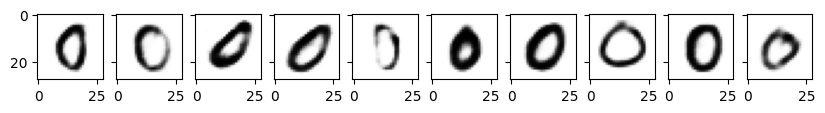

Class Label 1


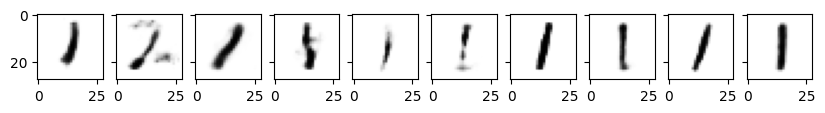

Class Label 2


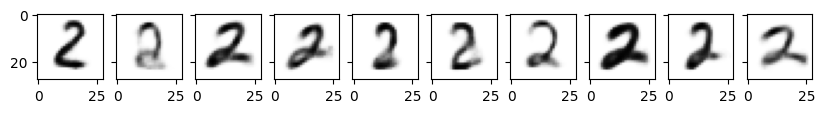

Class Label 3


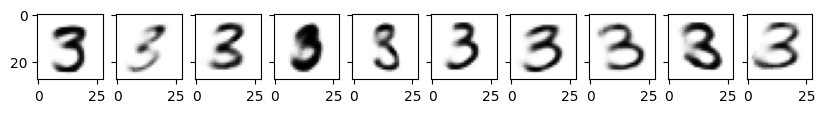

Class Label 4


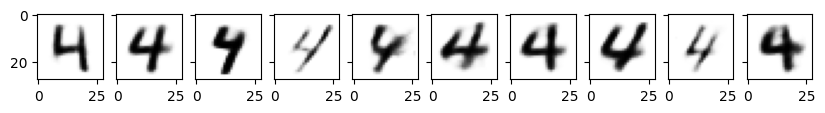

Class Label 5


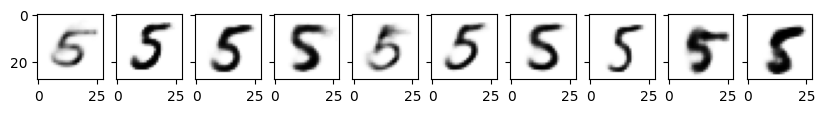

Class Label 6


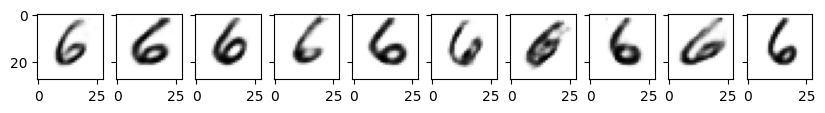

Class Label 7


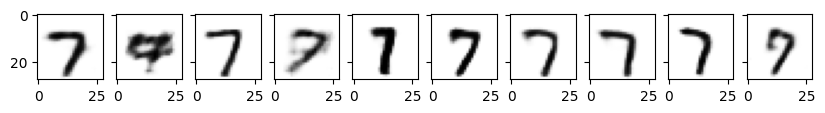

Class Label 8


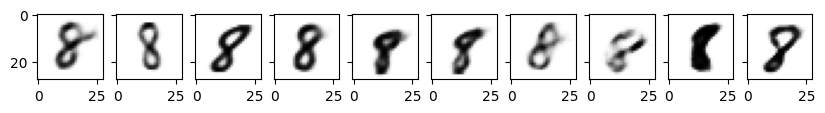

Class Label 9


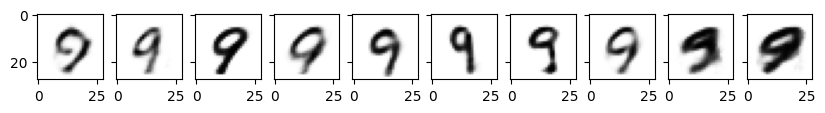

In [ ]:
##########################
### New random-conditional images
##########################

for i in range(10):

    ##########################
    ### RANDOM SAMPLE
    ##########################

    labels = torch.tensor([i]*10).to(device.type) #[i]*10: repite 10 veces un numero dado por i
    n_images = labels.size()[0]

    # rand_features: espacio latente aleatorio
    rand_features = torch.randn(n_images, num_latent).to(device.type) # crea tensor con números aleatorios de una distribución normal estándar del tamaño (dimensiones: n_images x num_latent)
    new_images = model.decoder(rand_features, labels)

    ##########################
    ### VISUALIZATION
    ##########################

    image_width = 28

    fig, axes = plt.subplots(nrows=1, ncols=n_images, figsize=(10, 2.5), sharey=True)
    decoded_images = new_images[:n_images][:, :-num_classes]

    print('Class Label %d' % i)

    for ax, img in zip(axes, decoded_images):
        curr_img = img.detach().to(torch.device('cpu'))
        ax.imshow(curr_img.view((image_width, image_width)), cmap='binary')

    plt.show()

In [ ]:
from sklearn.manifold import TSNE
import plotly.express as px
from tqdm import tqdm
import pandas as pd

In [ ]:
start_time_pandas = time.time()

encoded_samples = np.empty([0, num_latent])
encoded_labels = np.empty([0,1])

for sample in tqdm(data):
  # img = sample[0].squeeze(0).to(device.type)
  features = sample[0].view(-1, 28*28).to(device.type)
  # label = sample[1].to(device.type)
  targets = sample[1].to(device.type)

  model.eval()
  with torch.no_grad():
    # encoded_img  = vae.encoder(img)
    _, _, encoded_img, _ = model(features, targets)

  encoded_labels = np.append(encoded_labels, targets.cpu().numpy())
  encoded_samples = np.append(encoded_samples, encoded_img.cpu().numpy(), axis=0)

print('Total Time: %.2f min' % ((time.time() - start_time_pandas)/60))

100%|██████████| 469/469 [00:08<00:00, 53.11it/s]

Total Time: 0.15 min


In [ ]:
print(encoded_samples.shape)
print(encoded_labels.shape)

(60000, 35)
(60000,)


In [ ]:
start_time_tsne = time.time()

tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(encoded_samples)

fig = px.scatter(
        tsne_results, x=0, y=1,
        color=encoded_labels.astype(str),
        labels={'0': 'tsne-2d-one', '1': 'tsne-2d-two'}
      )
fig.show()

print('Total Time: %.2f min' % ((time.time() - start_time_tsne)/60))

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
encoded_samples_append = np.append(encoded_samples, encoded_labels[:,None], axis=1)
pd_encoded_samples = pd.DataFrame(encoded_samples_append, columns=[f'Variable {i}' for i in range(num_latent)] + ['label'])
pd_encoded_samples.head()

Variable 0  Variable 1  Variable 2  Variable 3  Variable 4  Variable 5  \
0   -0.474693    2.741269   -1.770821    0.098763   -0.125780    1.006937   
1    0.112392   -0.165472    0.129806   -0.071197   -0.454498    0.382746   
2   -1.286203    0.555796    1.375207    1.406155   -2.143014   -1.980080   
3   -1.972321    1.065937    0.201294    0.365132    0.095240    1.767488   
4   -1.230989   -0.914703    1.364562    1.128418   -0.601859    1.198282   

   Variable 6  Variable 7  label  
0    1.106361    0.312758    5.0  
1    0.386681    0.379028    0.0  
2    0.665560    0.484558    4.0  
3    0.260273    1.317973    1.0  
4   -1.368418   -0.757905    9.0

In [ ]:
# partial data with dataframe

start_time_tsne = time.time()

sample_df = pd_encoded_samples.groupby("label").sample(frac=0.3, random_state=1)

tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(sample_df.drop(['label'],axis=1))

fig = px.scatter(tsne_results, x=0, y=1, color=sample_df['label'].astype(str),labels={'0': 'tsne-2d-one', '1': 'tsne-2d-two'})
fig.show()

print('Total Time: %.2f min' % ((time.time() - start_time_tsne)/60))

Total Time: 6.45 min


# import CVAE

In [9]:
!pip install import-ipynb

In [45]:
import import_ipynb
import os
from google.colab import files
from importlib import reload
if not os.path.exists("/content/Model_CVAE.ipynb"): files.upload()
import Model_CVAE as mcvae
reload(mcvae)

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox, TextArea

from tqdm import tqdm
from sklearn.manifold import TSNE
import plotly.express as px

importing Jupyter notebook from Model_CVAE.ipynb


In [11]:
def train2(model, data, num_epochs=20, kl_version=2, reduction='sum'):

  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  losses = []

  start_time = time.time()
  for epoch in range(num_epochs):
    # for batch_idx, (features, targets) in enumerate(train_loader):

    loss = []

    for batch_idx, (features, targets) in enumerate(data):

      features = features.view(-1, 28*28).to(device.type)
      targets = targets.to(device.type)

      ### FORWARD AND BACK PROP
      optimizer.zero_grad() # Importante
      decoded = model(features, targets, kl_version)

      # cost = reconstruction loss + Kullback-Leibler divergence
      kl_divergence = model.encoder.kl_divergence

      # add condition
      x_con = torch.cat((features, to_onehot(targets, num_classes, device)), dim=1)

      pixelwise_bce = F.binary_cross_entropy(decoded, x_con, reduction=reduction)
      # pixelwise_bce = F.binary_cross_entropy(decoded, x_con, reduction='mean') # probar
      cost = kl_divergence + pixelwise_bce

      loss.append(cost)

      # optimizer.zero_grad() # no
      cost.backward()

      ### UPDATE MODEL PARAMETERS
      optimizer.step()

      ### LOGGING
      if not batch_idx % 50:
          print('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f | KL v%02d | reduction %s'
                  %(epoch+1, num_epochs, batch_idx, len(data.dataset)//batch_size, cost, kl_version, reduction))

    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    losses.append((sum(loss)/len(loss)).item())

  print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))
  return model, losses


In [ ]:
epoch = 1
cost = 9815
print('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f'
              %(epoch+1, num_epochs, batch_idx, len(data.dataset)/batch_size, cost))

Epoch: 002/050 | Batch 000/468 | Cost: 9815.0000


In [12]:
def reconstruction(trained_model, data, kl_version):
  n_images = 15
  image_width = 28

  fig, axes = plt.subplots(nrows=2, ncols=n_images, sharex=True, sharey=True, figsize=(20, 2.5))

  batch_idx, (features, targets) = next(enumerate(data))
  features = features.view(-1, 28*28).to(device)
  decoded = trained_model(features, targets.to(device), kl_version)

  orig_images = features[:n_images]
  decoded_images = decoded[:n_images][:, :-num_classes]

  for i in range(n_images):
      for ax, img in zip(axes, [orig_images, decoded_images]):
          curr_img = img[i].detach().to(torch.device('cpu'))
          ax[i].imshow(curr_img.view((image_width, image_width)), cmap='binary')
  plt.show()

In [13]:
def newRandomConditionalImages(trained_model):
  for i in range(10):

    ### RANDOM SAMPLE
    labels = torch.tensor([i]*10).to(device) #[i]*10: repite 10 veces un numero dado por i
    n_images = labels.size()[0]

    # rand_features: espacio latente aleatorio
    # crea tensor con números aleatorios de una distribución normal estándar del tamaño (dimensiones: n_images x num_latent)
    rand_features = torch.randn(n_images, num_latent).to(device)
    new_images = trained_model.decoder(rand_features, labels, device)

    ### VISUALIZATION
    image_width = 28

    fig, axes = plt.subplots(nrows=1, ncols=n_images, figsize=(10, 2.5), sharey=True)
    decoded_images = new_images[:n_images][:, :-num_classes]

    print('Class Label %d' % i)

    for ax, img in zip(axes, decoded_images):
      curr_img = img.detach().to(torch.device('cpu'))
      ax.imshow(curr_img.view((image_width, image_width)), cmap='binary')

    plt.show()

In [46]:
def getTrainedLatentVectorAndLabels(trained_model, data, kl_version):
  start_time_pandas = time.time()

  encoded_samples = np.empty([0, num_latent])
  labels = np.empty([0,1])
  input_imgs = np.empty([0, 28*28])

  for sample in tqdm(data):
    # img = sample[0].squeeze(0).to(device.type)
    features = sample[0].view(-1, 28*28).to(device.type)
    # label = sample[1].to(device.type)
    targets = sample[1].to(device.type)

    trained_model.eval()
    with torch.no_grad():
      encoded_img = trained_model.encoder(features, targets, device, kl_version)

    labels = np.append(labels, targets.cpu().numpy())
    encoded_samples = np.append(encoded_samples, encoded_img.cpu().numpy(), axis=0)
    input_imgs = np.append(input_imgs, features.cpu().numpy(), axis=0)

  print('Total Time: %.2f min' % ((time.time() - start_time_pandas)/60))
  return encoded_samples, labels, input_imgs

In [59]:
def plot_tsne(trained_model, data, kl_version, frac=0):

  encoded_samples, labels, _ = getTrainedLatentVectorAndLabels(trained_model, data, kl_version)
  if frac > 0:
    encoded_samples_df = np.append(encoded_samples, labels[:,None], axis=1)
    encoded_samples_df = pd.DataFrame(encoded_samples_df, columns=[f'Variable {i}' for i in range(encoded_samples.shape[1])] + ['label'])
    encoded_samples_df = encoded_samples_df.groupby("label").sample(frac=frac, random_state=1)
    encoded_samples = encoded_samples_df.drop(['label'],axis=1)
    labels = encoded_samples_df['label']

  print("ok load data")
  print("start build TSNE")

  start_time_tsne = time.time()

  tsne = TSNE(n_components=2,random_state=42)
  tsne_results = tsne.fit_transform(encoded_samples)

  fig = px.scatter(
          tsne_results, x=0, y=1,
          color=labels.astype(str),
          labels={'0': 'tsne-2d-one', '1': 'tsne-2d-two'}
        )
  fig.show()

  print('Total Time: %.2f min' % ((time.time() - start_time_tsne)/60))

In [95]:
def plot_tsne2(trained_model, data, kl_version, frac=0, mode='dots'):

  # img_inputs,latent_vectors,latent_labels = get_latent_data(net=net, count=count, is_cvae=is_cvae)
  encoded_samples, labels, img_inputs = getTrainedLatentVectorAndLabels(trained_model, data, kl_version)

  if frac > 0:
    encoded_samples_df = np.append(encoded_samples, labels[:,None], axis=1)
    encoded_samples_df = pd.DataFrame(encoded_samples_df, columns=[f'Variable {i}' for i in range(encoded_samples.shape[1])] + ['label'])
    encoded_samples_df = encoded_samples_df.groupby("label").sample(frac=frac, random_state=1)
    encoded_samples = encoded_samples_df.drop(['label'],axis=1)
    labels = encoded_samples_df['label']

  print("ok load data")
  print("start build TSNE")

  start_time_tsne = time.time()

  fig, ax = plt.subplots(figsize=(15, 9))
  ax.set_title('t-SNE')
  # andom_state is used as seed for pseudorandom number generator in scikit-learn to duplicate the behavior
  coords = TSNE(n_components=2,random_state=42).fit_transform(encoded_samples)

  if mode == 'imgs':
    for image, (x, y) in zip(img_inputs.cpu(), coords):
      im = OffsetImage(image.reshape(28, 28), zoom=1, cmap='gray')
      ab = AnnotationBbox(im, (x, y), xycoords='data', frameon=False)
      ax.add_artist(ab)
    ax.update_datalim(coords)
    ax.autoscale()

  elif mode == 'dots':
    classes = labels
    plt.scatter(coords[:, 0], coords[:, 1], c=classes)
    plt.colorbar()
    for i in range(10):
      class_center = np.mean(coords[classes == i], axis=0)
      text = TextArea('{}'.format(i))
      ab = AnnotationBbox(text, class_center, xycoords='data', frameon=True)
      ax.add_artist(ab)
  plt.show()
  print('Total Time: %.2f min' % ((time.time() - start_time_tsne)/60))

In [65]:
def plot_losses(val_loss):
  plt.figure(figsize=(15, 9))
  plt.plot(val_loss, label="loss")
  plt.legend(loc='best')
  plt.xlabel("epochs")
  plt.ylabel("loss")
  plt.show()

### Train with kl_version 1 VAE and reduction sum



In [18]:
print("Device:", device)
modelCVAE = mcvae.ConditionalVariationalAutoencoder(
              latent_dims= num_latent,
              num_features= num_features,
              num_hidden_layers= num_hidden_1,
              num_classes= num_classes
            )
modelCVAE = modelCVAE.to(device.type)

kl_version = 1
trained_cvae_v1_sum, losses_v1_sum = train2(modelCVAE, data, num_epochs, kl_version, reduction='sum')

Device: cuda:0
Epoch: 001/050 | Batch 000/468 | Cost: 70771.4375 | KL v01 ! reduction sum
Epoch: 001/050 | Batch 050/468 | Cost: 26187.8574 | KL v01 ! reduction sum
Epoch: 001/050 | Batch 100/468 | Cost: 20208.2598 | KL v01 ! reduction sum
Epoch: 001/050 | Batch 150/468 | Cost: 19002.1055 | KL v01 ! reduction sum
Epoch: 001/050 | Batch 200/468 | Cost: 16374.3018 | KL v01 ! reduction sum
Epoch: 001/050 | Batch 250/468 | Cost: 15711.2852 | KL v01 ! reduction sum
Epoch: 001/050 | Batch 300/468 | Cost: 14573.9023 | KL v01 ! reduction sum
Epoch: 001/050 | Batch 350/468 | Cost: 15259.4932 | KL v01 ! reduction sum
Epoch: 001/050 | Batch 400/468 | Cost: 14100.5820 | KL v01 ! reduction sum
Epoch: 001/050 | Batch 450/468 | Cost: 14166.1592 | KL v01 ! reduction sum
Time elapsed: 0.23 min
Epoch: 002/050 | Batch 000/468 | Cost: 13485.5547 | KL v01 ! reduction sum
Epoch: 002/050 | Batch 050/468 | Cost: 13729.0771 | KL v01 ! reduction sum
Epoch: 002/050 | Batch 100/468 | Cost: 13865.3906 | KL v01 ! r

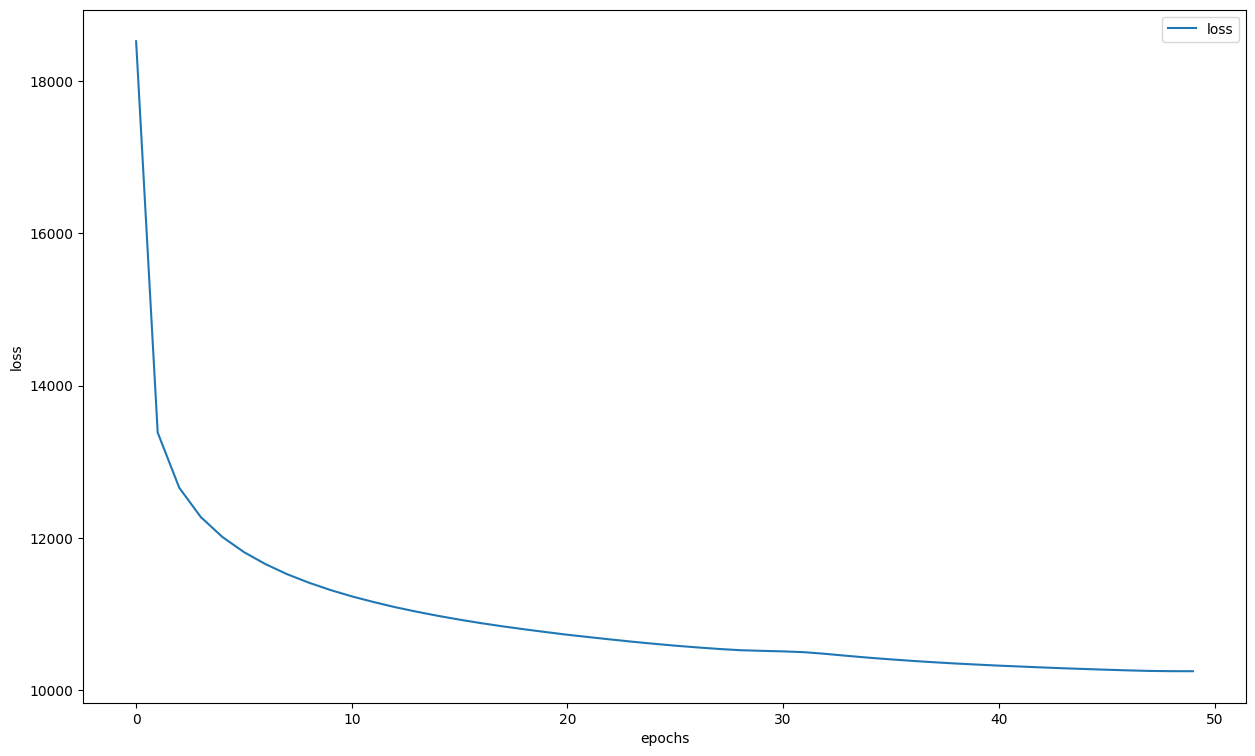

In [66]:
plot_losses(losses_v1_sum)

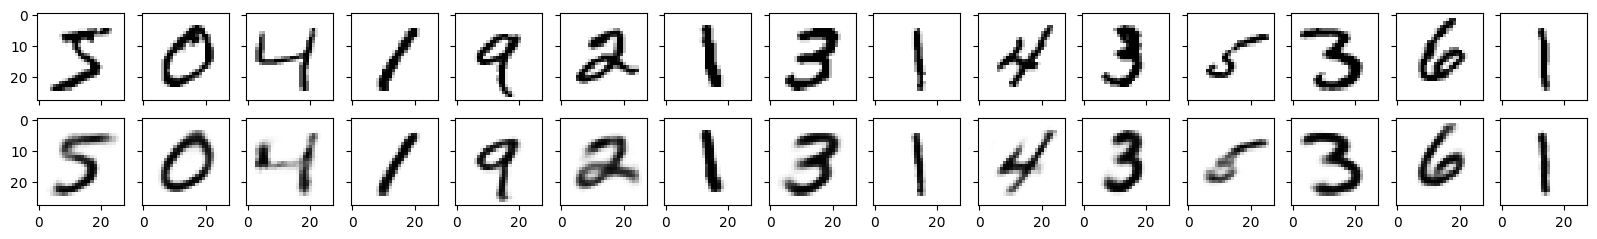

In [33]:
reconstruction(trained_cvae_v1_sum, data, kl_version)

Class Label 0


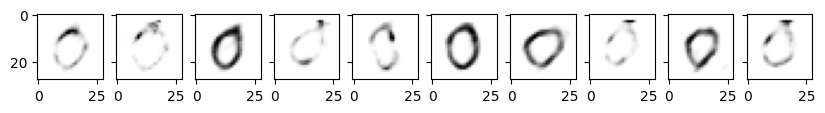

Class Label 1


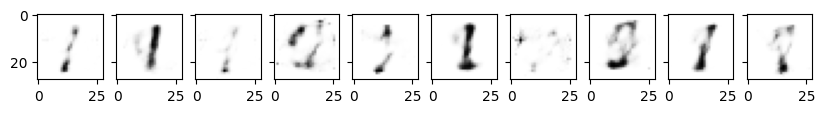

Class Label 2


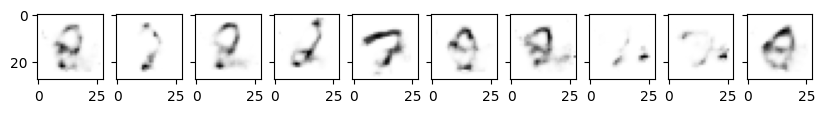

Class Label 3


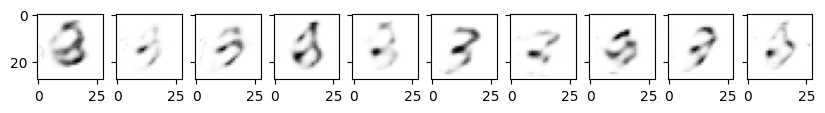

Class Label 4


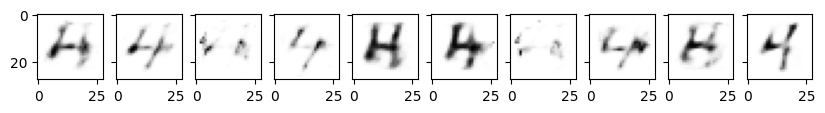

Class Label 5


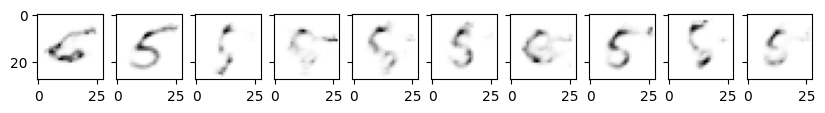

Class Label 6


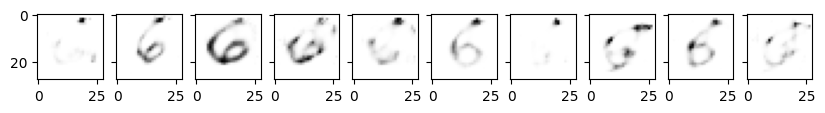

Class Label 7


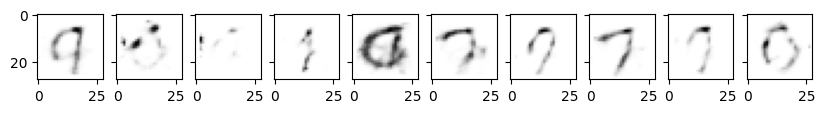

Class Label 8


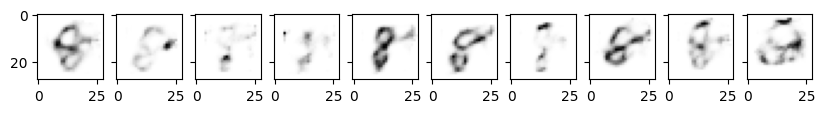

Class Label 9


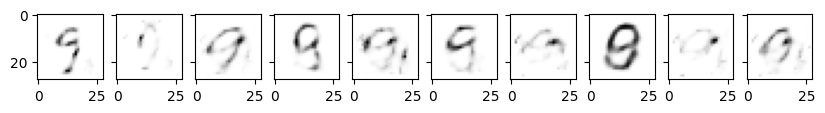

In [24]:
newRandomConditionalImages(trained_cvae_v1_sum)

In [60]:
plot_tsne(trained_cvae_v1_sum, data, kl_version, frac=0.3)

100%|██████████| 469/469 [00:43<00:00, 10.76it/s]


Total Time: 0.73 min
ok load data
start build TSNE


Total Time: 2.82 min


100%|██████████| 469/469 [00:44<00:00, 10.43it/s]


Total Time: 0.75 min
ok load data
start build TSNE


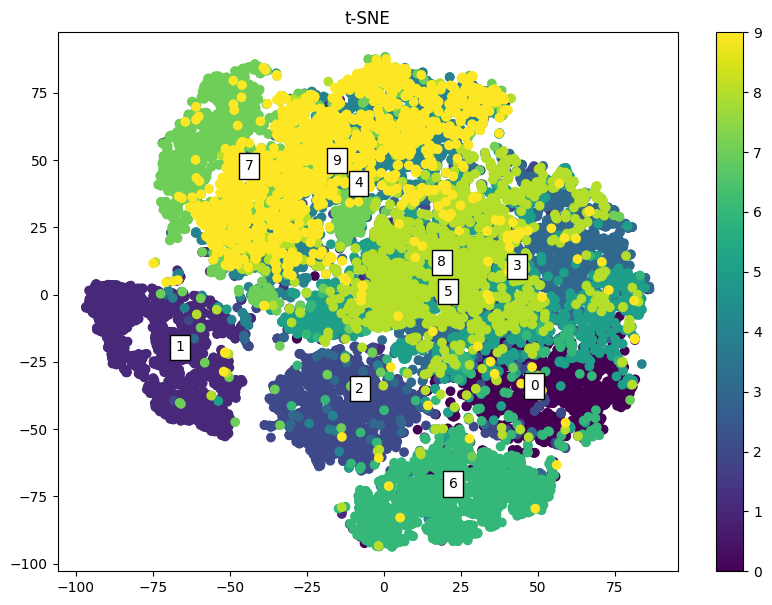

Total Time: 2.91 min


In [62]:
plot_tsne2(trained_cvae_v1_sum, data, kl_version, frac=0.3)

100%|██████████| 469/469 [00:44<00:00, 10.66it/s]


Total Time: 0.73 min
ok load data
start build TSNE


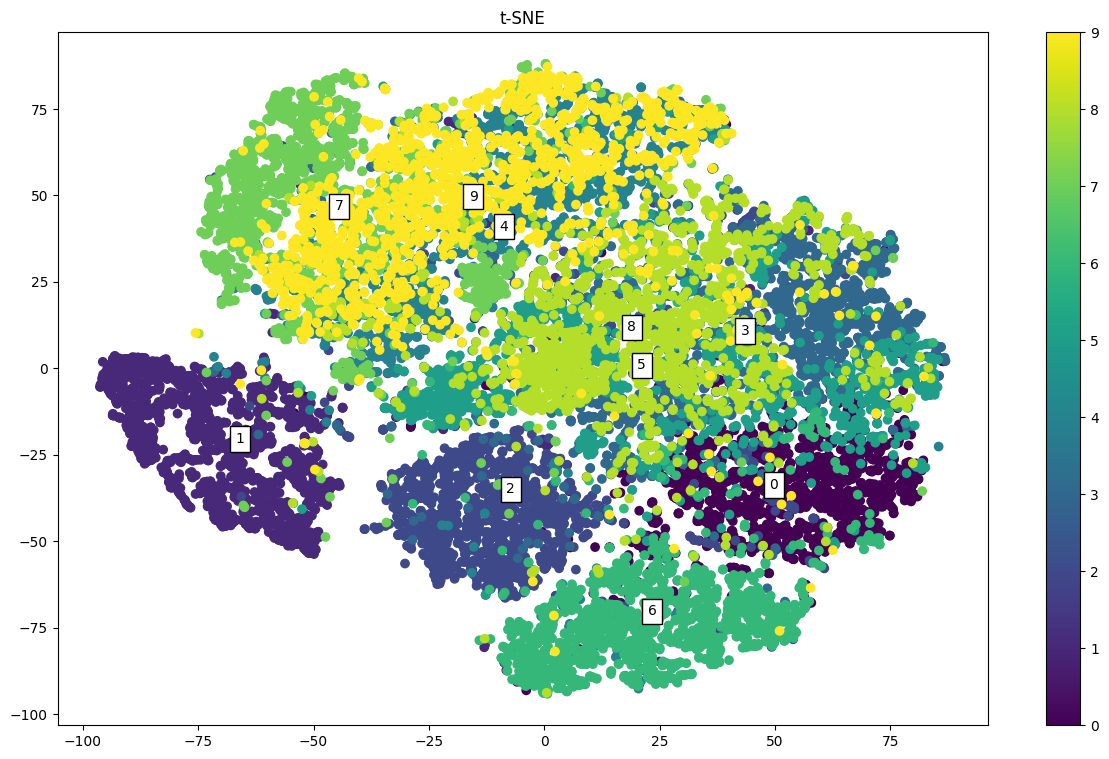

Total Time: 2.91 min


In [96]:
plot_tsne2(trained_cvae_v1_sum, data, kl_version=1, frac=0.3)

### Train with kl_version 1 VAE and reduction mean


In [63]:
print("Device:", device)
modelCVAE = mcvae.ConditionalVariationalAutoencoder(
              latent_dims= num_latent,
              num_features= num_features,
              num_hidden_layers= num_hidden_1,
              num_classes= num_classes
            )
modelCVAE = modelCVAE.to(device.type)

kl_version = 1
trained_cvae_v1_mean, losses_v1_mean = train2(modelCVAE, data, num_epochs, kl_version, reduction='mean')

Device: cuda:0
Epoch: 001/050 | Batch 000/468 | Cost: 0.7383 | KL v01 ! reduction mean
Epoch: 001/050 | Batch 050/468 | Cost: 0.2702 | KL v01 ! reduction mean
Epoch: 001/050 | Batch 100/468 | Cost: 0.2470 | KL v01 ! reduction mean
Epoch: 001/050 | Batch 150/468 | Cost: 0.2495 | KL v01 ! reduction mean
Epoch: 001/050 | Batch 200/468 | Cost: 0.2307 | KL v01 ! reduction mean
Epoch: 001/050 | Batch 250/468 | Cost: 0.2308 | KL v01 ! reduction mean
Epoch: 001/050 | Batch 300/468 | Cost: 0.2088 | KL v01 ! reduction mean
Epoch: 001/050 | Batch 350/468 | Cost: 0.2240 | KL v01 ! reduction mean
Epoch: 001/050 | Batch 400/468 | Cost: 0.2399 | KL v01 ! reduction mean
Epoch: 001/050 | Batch 450/468 | Cost: 0.2153 | KL v01 ! reduction mean
Time elapsed: 0.35 min
Epoch: 002/050 | Batch 000/468 | Cost: 0.2122 | KL v01 ! reduction mean
Epoch: 002/050 | Batch 050/468 | Cost: 0.2245 | KL v01 ! reduction mean
Epoch: 002/050 | Batch 100/468 | Cost: 0.2188 | KL v01 ! reduction mean
Epoch: 002/050 | Batch 150

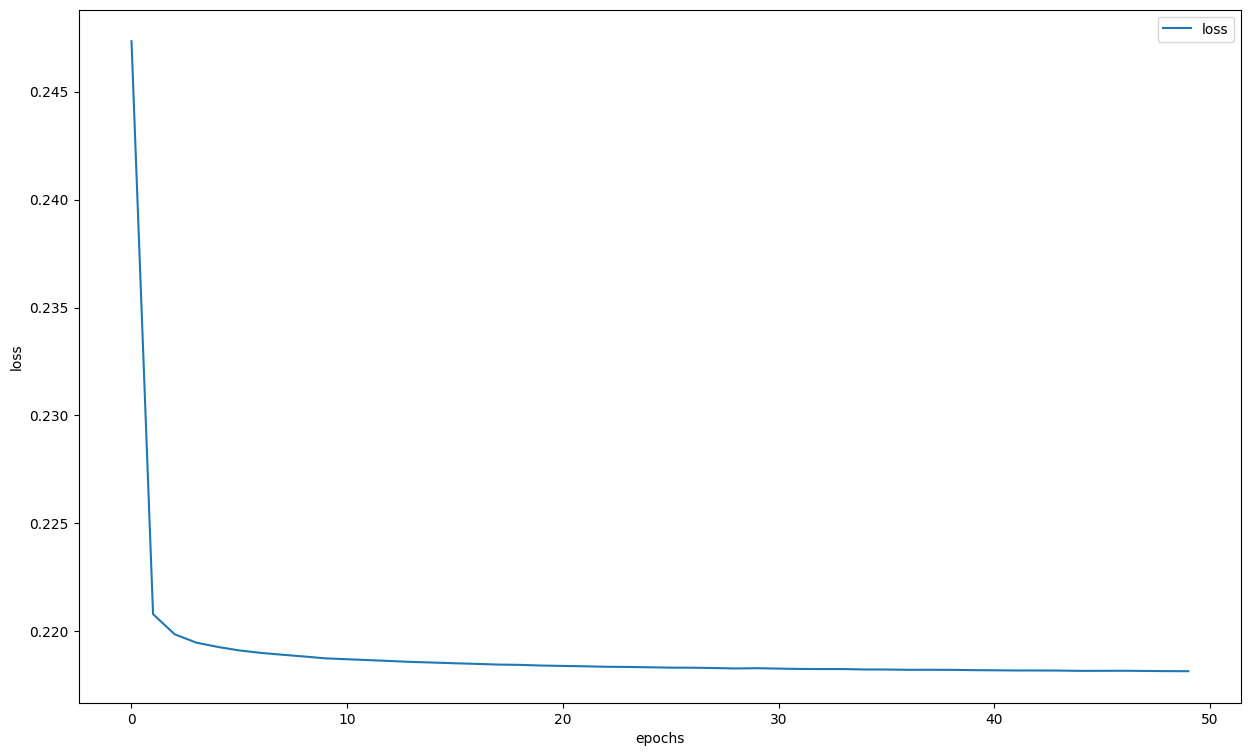

In [67]:
plot_losses(losses_v1_mean)

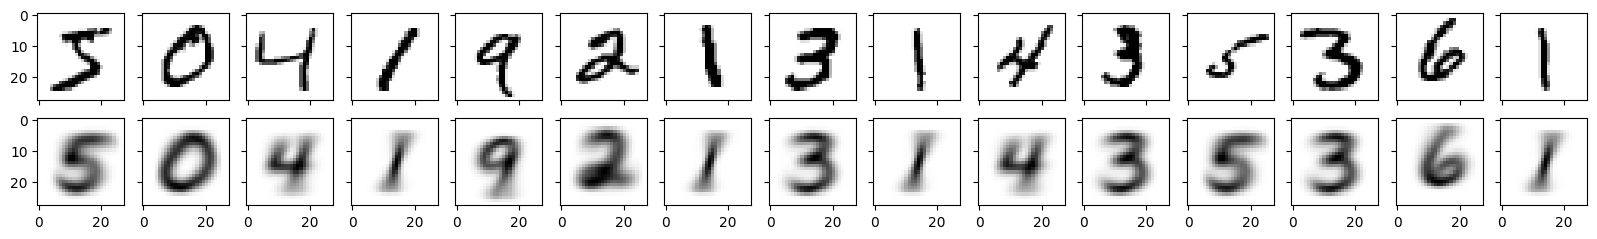

In [68]:
reconstruction(trained_cvae_v1_mean, data, kl_version)

Class Label 0


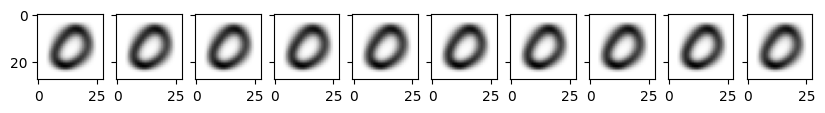

Class Label 1


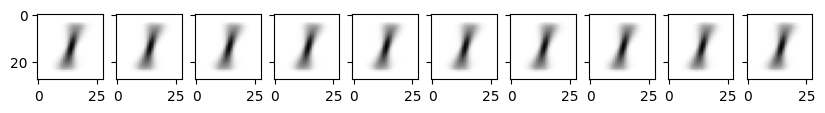

Class Label 2


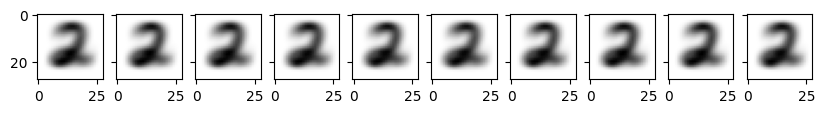

Class Label 3


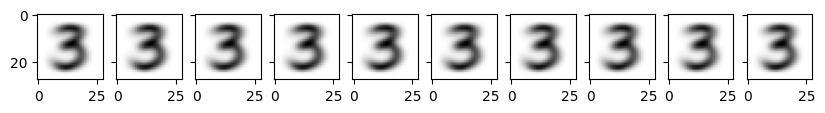

Class Label 4


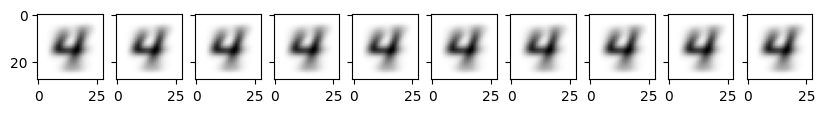

Class Label 5


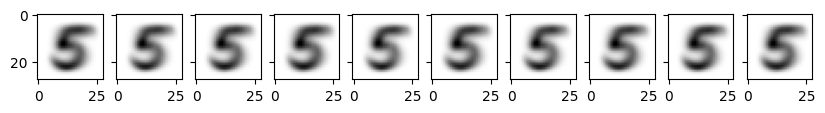

Class Label 6


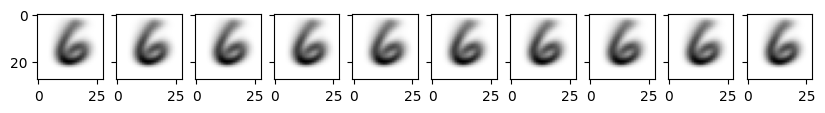

Class Label 7


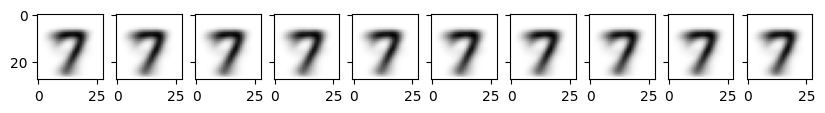

Class Label 8


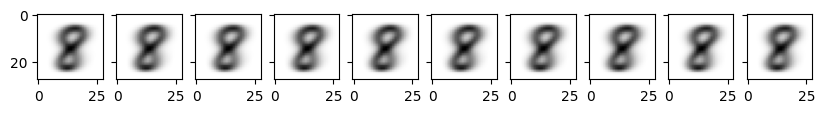

Class Label 9


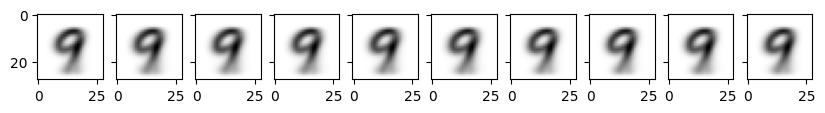

In [69]:
newRandomConditionalImages(trained_cvae_v1_mean)

In [71]:
plot_tsne(trained_cvae_v1_mean, data, kl_version, frac=0.3)

100%|██████████| 469/469 [00:51<00:00,  9.07it/s]


Total Time: 0.86 min
ok load data
start build TSNE


Total Time: 3.05 min


100%|██████████| 469/469 [00:44<00:00, 10.58it/s]


Total Time: 0.74 min
ok load data
start build TSNE


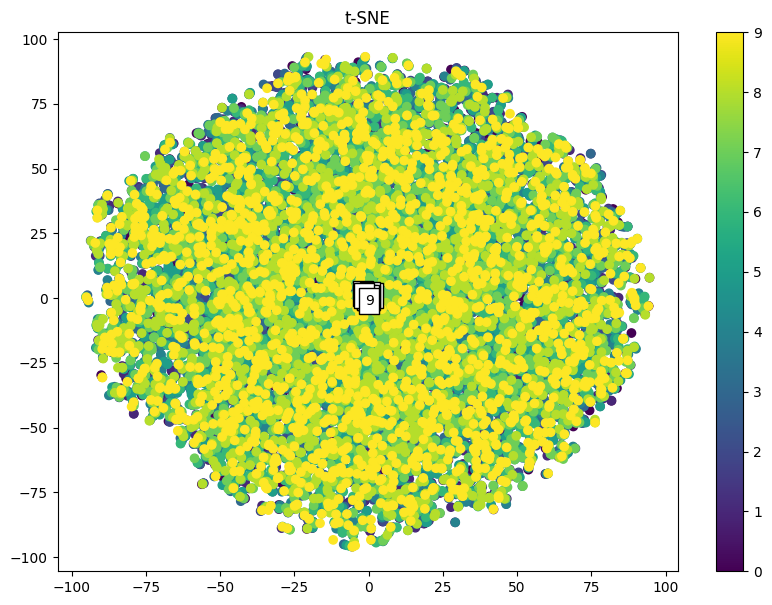

Total Time: 3.03 min


In [72]:
plot_tsne2(trained_cvae_v1_mean, data, kl_version, frac=0.3)

### Train with kl_version 2 CVAE and sum

In [73]:
print("Device:", device)
modelCVAE = mcvae.ConditionalVariationalAutoencoder(
              latent_dims= num_latent,
              num_features= num_features,
              num_hidden_layers= num_hidden_1,
              num_classes= num_classes
            )
modelCVAE = modelCVAE.to(device.type)

kl_version = 2
trained_cvae_v2_sum, losses_v2_sum = train2(modelCVAE, data, num_epochs, kl_version, reduction='sum')

Device: cuda:0
Epoch: 001/050 | Batch 000/468 | Cost: 71139.3281 | KL v02 ! reduction sum
Epoch: 001/050 | Batch 050/468 | Cost: 27028.3945 | KL v02 ! reduction sum
Epoch: 001/050 | Batch 100/468 | Cost: 22362.5391 | KL v02 ! reduction sum
Epoch: 001/050 | Batch 150/468 | Cost: 21264.1113 | KL v02 ! reduction sum
Epoch: 001/050 | Batch 200/468 | Cost: 19154.6816 | KL v02 ! reduction sum
Epoch: 001/050 | Batch 250/468 | Cost: 18337.0430 | KL v02 ! reduction sum
Epoch: 001/050 | Batch 300/468 | Cost: 17138.6348 | KL v02 ! reduction sum
Epoch: 001/050 | Batch 350/468 | Cost: 17882.3691 | KL v02 ! reduction sum
Epoch: 001/050 | Batch 400/468 | Cost: 17090.5781 | KL v02 ! reduction sum
Epoch: 001/050 | Batch 450/468 | Cost: 16961.5488 | KL v02 ! reduction sum
Time elapsed: 0.15 min
Epoch: 002/050 | Batch 000/468 | Cost: 16249.3604 | KL v02 ! reduction sum
Epoch: 002/050 | Batch 050/468 | Cost: 16551.7012 | KL v02 ! reduction sum
Epoch: 002/050 | Batch 100/468 | Cost: 16473.7539 | KL v02 ! r

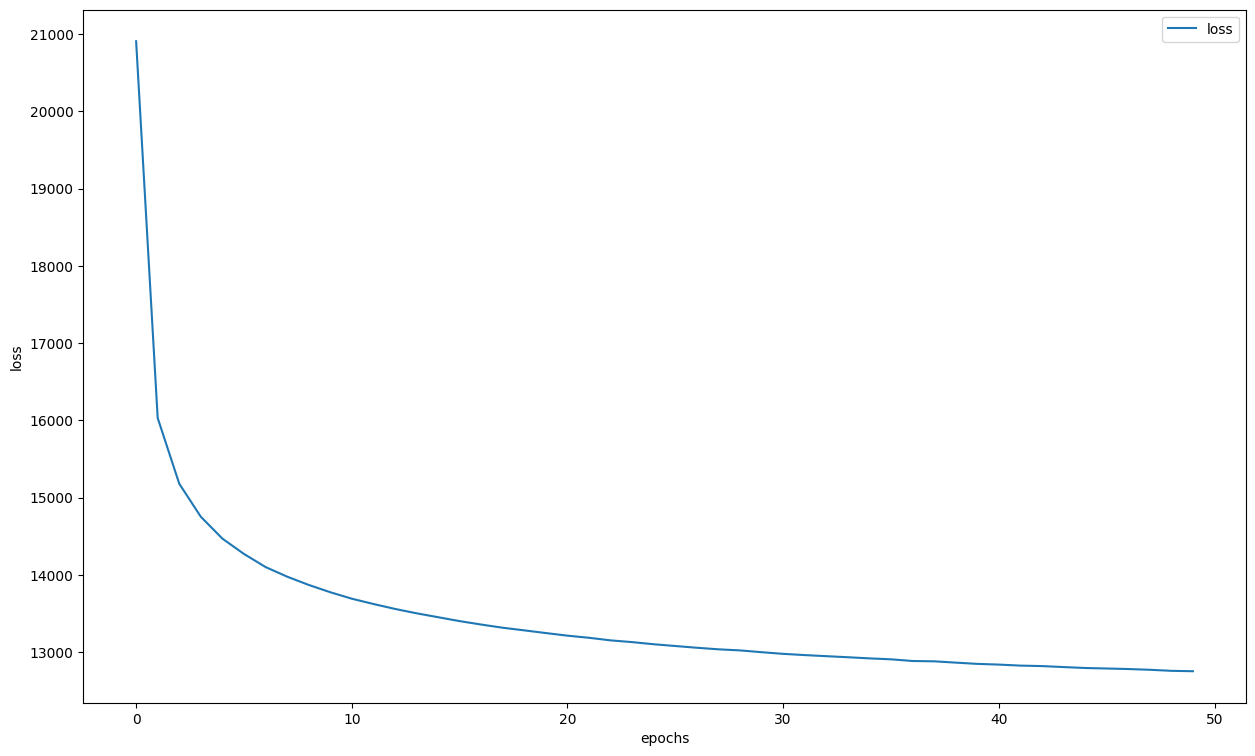

In [74]:
plot_losses(losses_v2_sum)

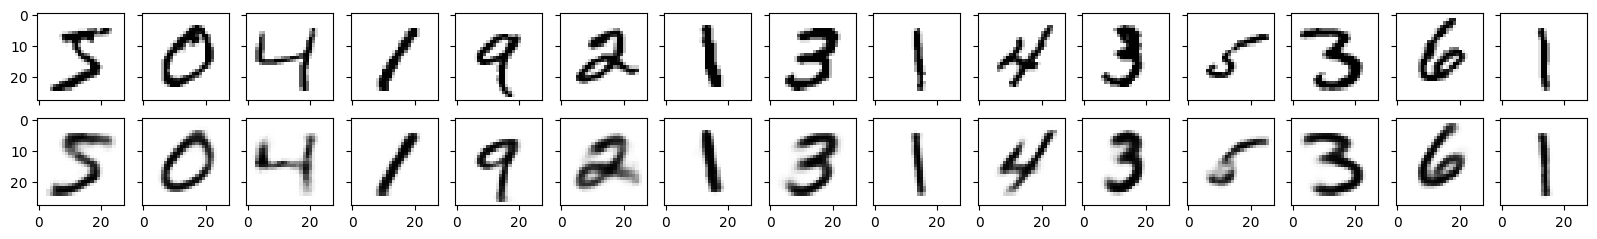

In [75]:
reconstruction(trained_cvae_v2_sum, data, kl_version)

Class Label 0


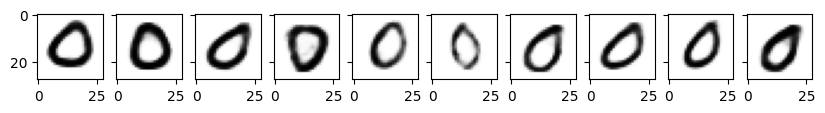

Class Label 1


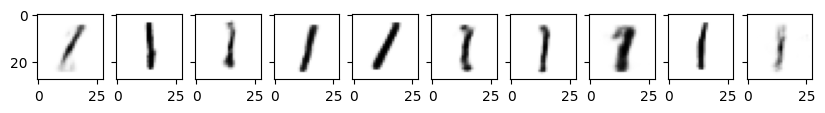

Class Label 2


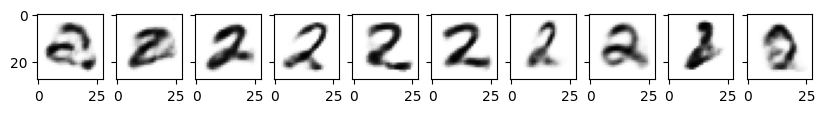

Class Label 3


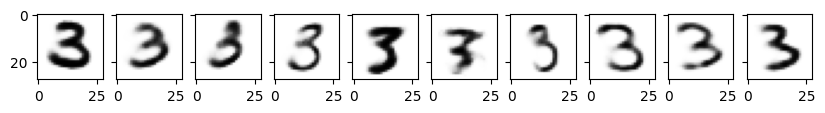

Class Label 4


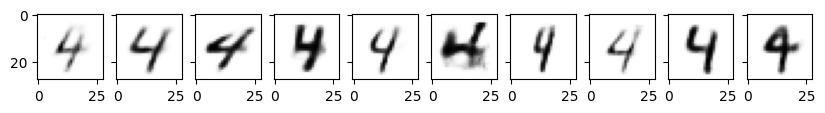

Class Label 5


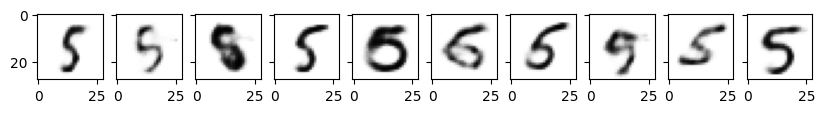

Class Label 6


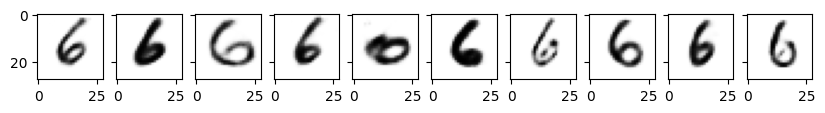

Class Label 7


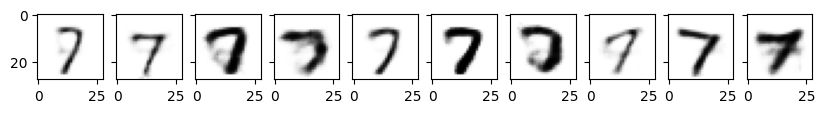

Class Label 8


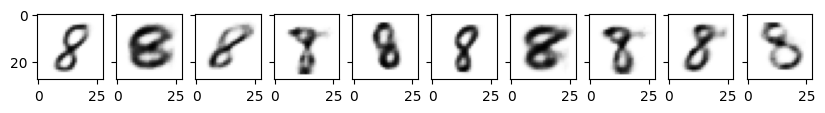

Class Label 9


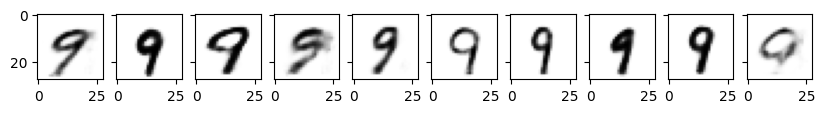

In [76]:
newRandomConditionalImages(trained_cvae_v2_sum)

In [78]:
plot_tsne(trained_cvae_v2_sum, data, kl_version, frac=0.3)

100%|██████████| 469/469 [00:49<00:00,  9.51it/s]


Total Time: 0.82 min
ok load data
start build TSNE


Total Time: 6.40 min


100%|██████████| 469/469 [00:44<00:00, 10.51it/s]


Total Time: 0.74 min
ok load data
start build TSNE


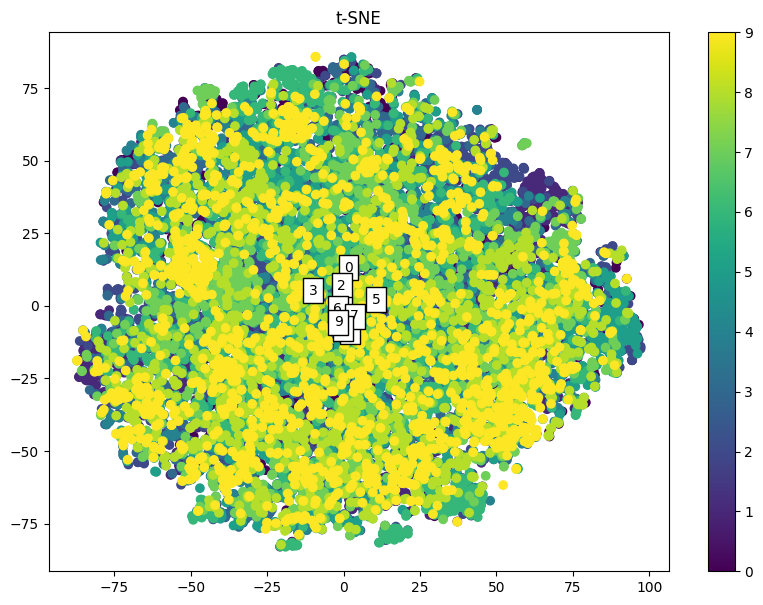

Total Time: 6.27 min


In [79]:
plot_tsne2(trained_cvae_v2_sum, data, kl_version, frac=0.3)

### Train with kl_version 2 CVAE and mean

In [80]:
print("Device:", device)
modelCVAE = mcvae.ConditionalVariationalAutoencoder(
              latent_dims= num_latent,
              num_features= num_features,
              num_hidden_layers= num_hidden_1,
              num_classes= num_classes
            )
modelCVAE = modelCVAE.to(device.type)

kl_version = 2
trained_cvae_v2_mean, losses_v2_mean = train2(modelCVAE, data, num_epochs, kl_version, reduction='mean')

Device: cuda:0
Epoch: 001/050 | Batch 000/468 | Cost: 8.1070 | KL v02 ! reduction mean
Epoch: 001/050 | Batch 050/468 | Cost: 0.3323 | KL v02 ! reduction mean
Epoch: 001/050 | Batch 100/468 | Cost: 0.2727 | KL v02 ! reduction mean
Epoch: 001/050 | Batch 150/468 | Cost: 0.2669 | KL v02 ! reduction mean
Epoch: 001/050 | Batch 200/468 | Cost: 0.2362 | KL v02 ! reduction mean
Epoch: 001/050 | Batch 250/468 | Cost: 0.2366 | KL v02 ! reduction mean
Epoch: 001/050 | Batch 300/468 | Cost: 0.2123 | KL v02 ! reduction mean
Epoch: 001/050 | Batch 350/468 | Cost: 0.2283 | KL v02 ! reduction mean
Epoch: 001/050 | Batch 400/468 | Cost: 0.2434 | KL v02 ! reduction mean
Epoch: 001/050 | Batch 450/468 | Cost: 0.2171 | KL v02 ! reduction mean
Time elapsed: 0.16 min
Epoch: 002/050 | Batch 000/468 | Cost: 0.2150 | KL v02 ! reduction mean
Epoch: 002/050 | Batch 050/468 | Cost: 0.2256 | KL v02 ! reduction mean
Epoch: 002/050 | Batch 100/468 | Cost: 0.2204 | KL v02 ! reduction mean
Epoch: 002/050 | Batch 150

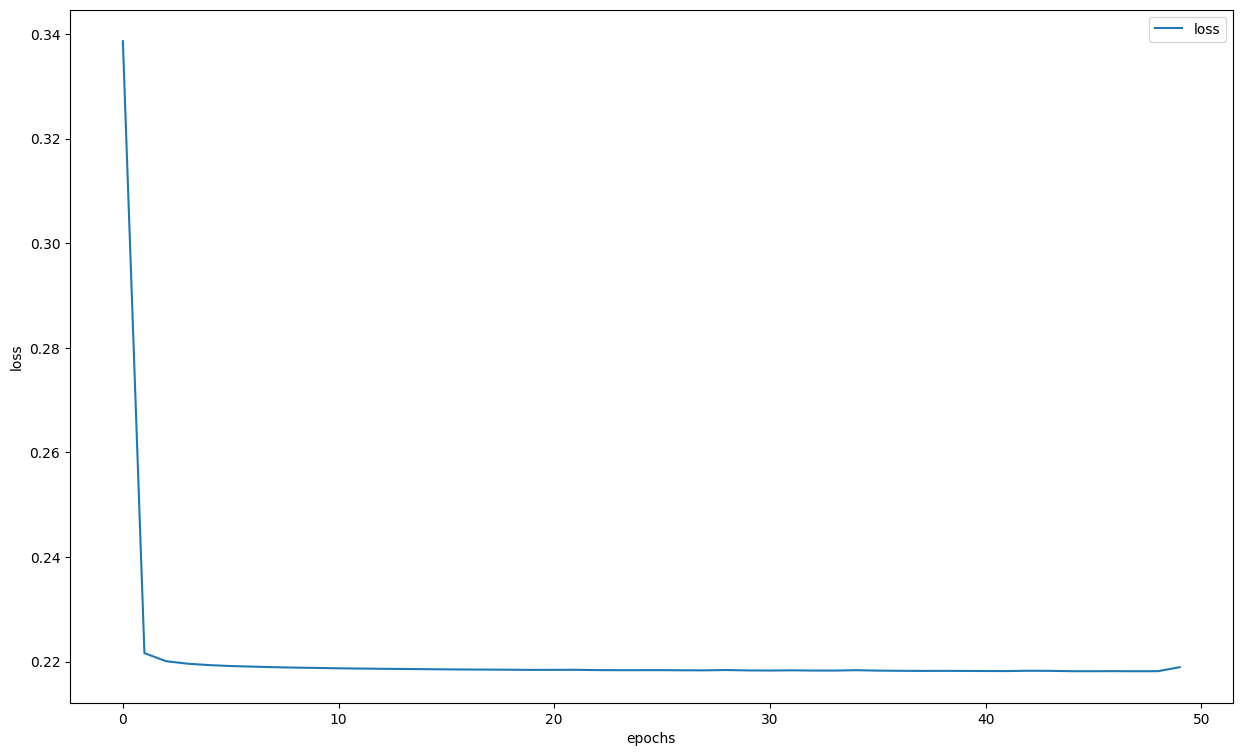

In [81]:
plot_losses(losses_v2_mean)

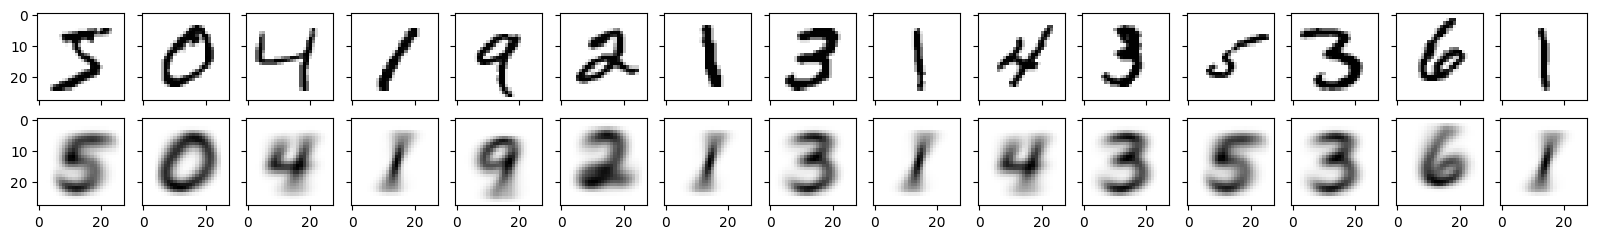

In [82]:
reconstruction(trained_cvae_v2_mean, data, kl_version)

Class Label 0


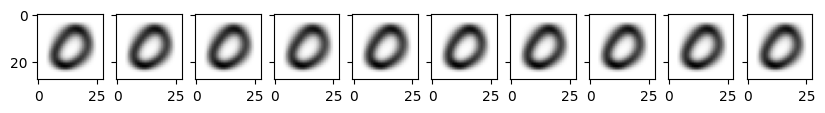

Class Label 1


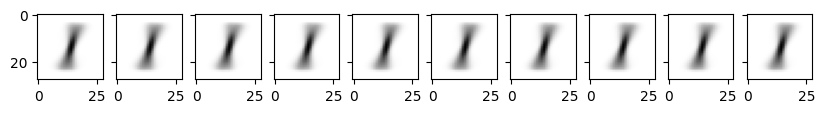

Class Label 2


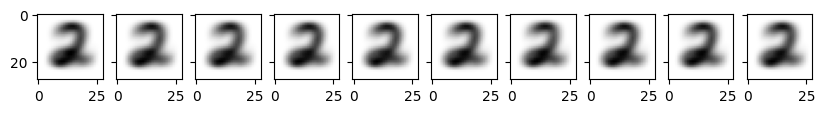

Class Label 3


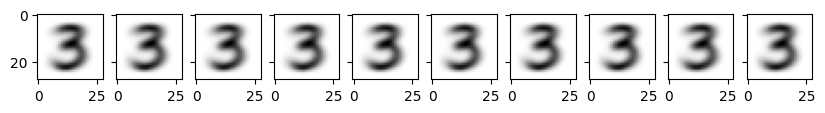

Class Label 4


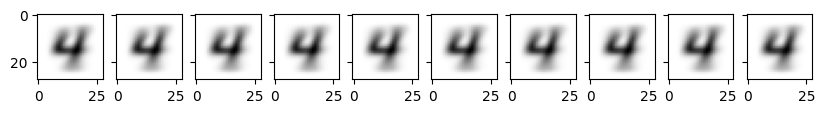

Class Label 5


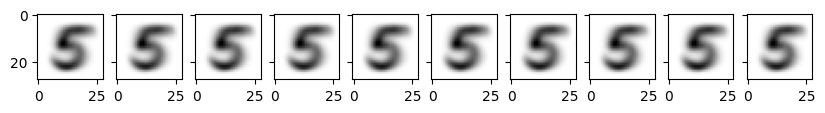

Class Label 6


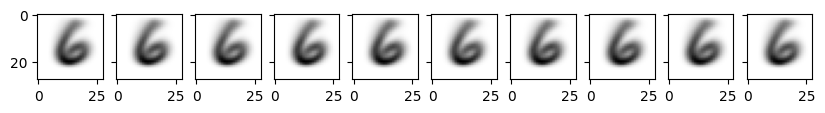

Class Label 7


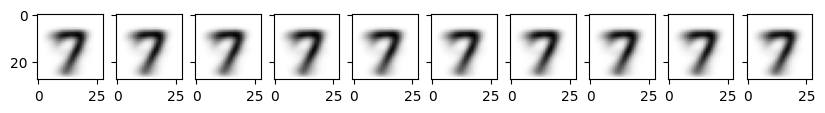

Class Label 8


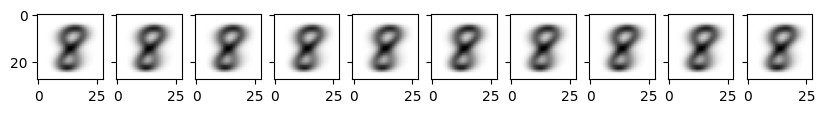

Class Label 9


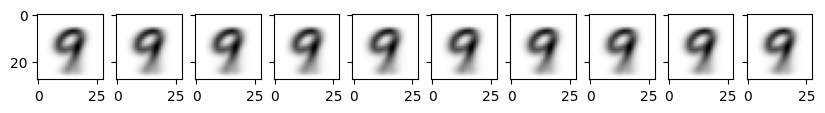

In [83]:
newRandomConditionalImages(trained_cvae_v2_mean)

In [85]:
plot_tsne(trained_cvae_v2_mean, data, kl_version, frac=0.3)

100%|██████████| 469/469 [00:47<00:00,  9.86it/s]


Total Time: 0.79 min
ok load data
start build TSNE


Total Time: 3.03 min


### Train with kl_version 3

In [86]:
print("Device:", device)
modelCVAE = mcvae.ConditionalVariationalAutoencoder(
              latent_dims= num_latent,
              num_features= num_features,
              num_hidden_layers= num_hidden_1,
              num_classes= num_classes
            )
modelCVAE = modelCVAE.to(device.type)

kl_version = 3
trained_cvae_v3, losses_v3 = train2(modelCVAE, data, num_epochs, kl_version)

Device: cuda:0


RuntimeError: ignored

In [ ]:
plot_losses(losses_v3)

In [ ]:
reconstruction(trained_cvae_v3, data)

In [ ]:
newRandomConditionalImages(trained_cvae_v3)

In [ ]:
plot_tsne(trained_cvae_v3, data, frac=0.3)

### Train with kl_version 4 and reduction sum

In [87]:
print("Device:", device)
modelCVAE = mcvae.ConditionalVariationalAutoencoder(
              latent_dims= num_latent,
              num_features= num_features,
              num_hidden_layers= num_hidden_1,
              num_classes= num_classes
            )
modelCVAE = modelCVAE.to(device.type)

kl_version = 4
trained_cvae_v4, losses_v4 = train2(modelCVAE, data, num_epochs, kl_version)

Device: cuda:0
Epoch: 001/050 | Batch 000/468 | Cost: 70995.8906 | KL v04 ! reduction sum
Epoch: 001/050 | Batch 050/468 | Cost: 27152.1230 | KL v04 ! reduction sum
Epoch: 001/050 | Batch 100/468 | Cost: 22281.7695 | KL v04 ! reduction sum
Epoch: 001/050 | Batch 150/468 | Cost: 21135.5137 | KL v04 ! reduction sum
Epoch: 001/050 | Batch 200/468 | Cost: 19059.5566 | KL v04 ! reduction sum
Epoch: 001/050 | Batch 250/468 | Cost: 18305.2246 | KL v04 ! reduction sum
Epoch: 001/050 | Batch 300/468 | Cost: 17079.3770 | KL v04 ! reduction sum
Epoch: 001/050 | Batch 350/468 | Cost: 17622.1895 | KL v04 ! reduction sum
Epoch: 001/050 | Batch 400/468 | Cost: 16740.1465 | KL v04 ! reduction sum
Epoch: 001/050 | Batch 450/468 | Cost: 16748.4531 | KL v04 ! reduction sum
Time elapsed: 0.16 min
Epoch: 002/050 | Batch 000/468 | Cost: 16121.8867 | KL v04 ! reduction sum
Epoch: 002/050 | Batch 050/468 | Cost: 16395.9043 | KL v04 ! reduction sum
Epoch: 002/050 | Batch 100/468 | Cost: 16374.9395 | KL v04 ! r

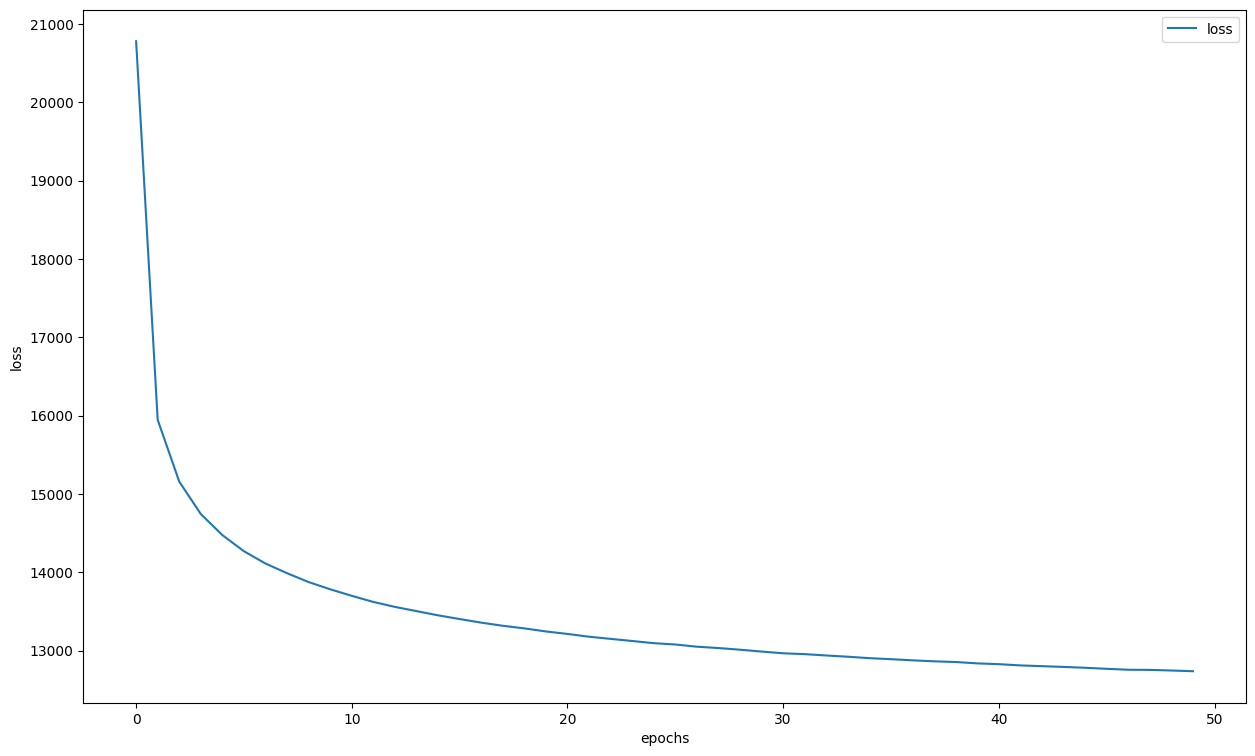

50


In [107]:
plot_losses(losses_v4)
print(len(losses_v4))

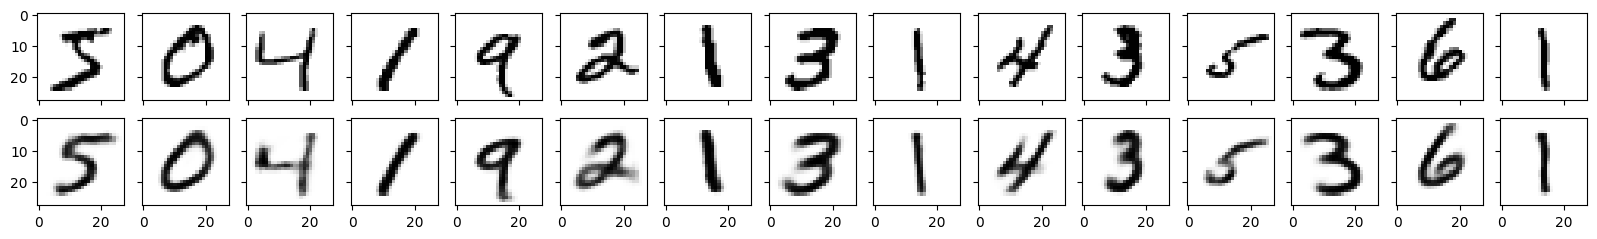

In [89]:
reconstruction(trained_cvae_v4, data, kl_version)

Class Label 0


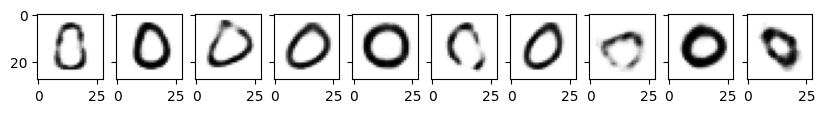

Class Label 1


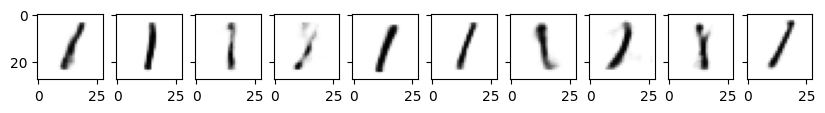

Class Label 2


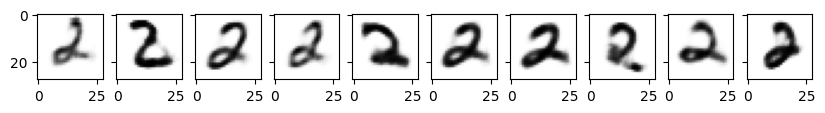

Class Label 3


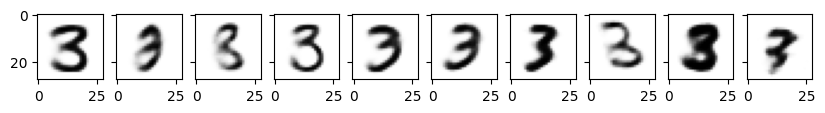

Class Label 4


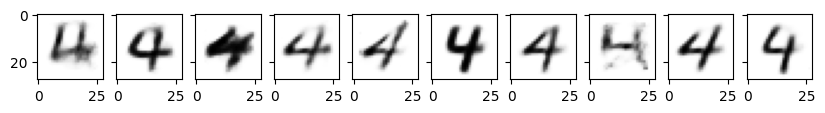

Class Label 5


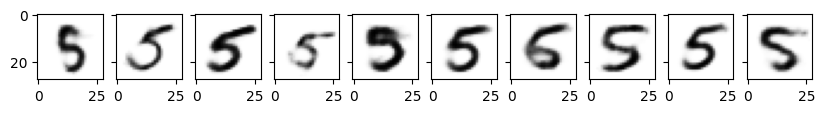

Class Label 6


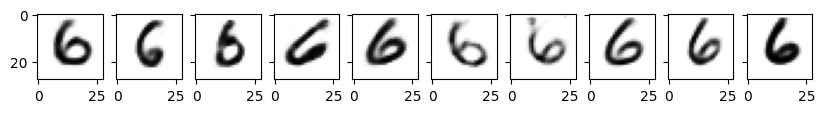

Class Label 7


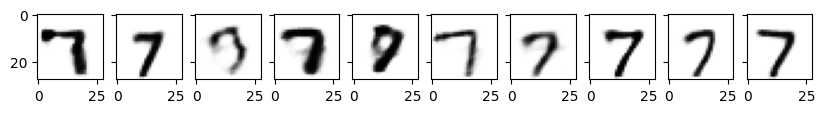

Class Label 8


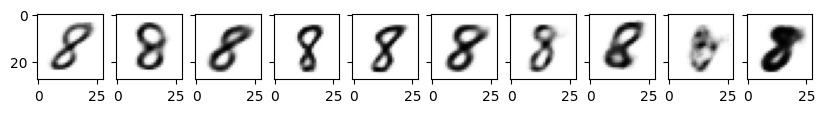

Class Label 9


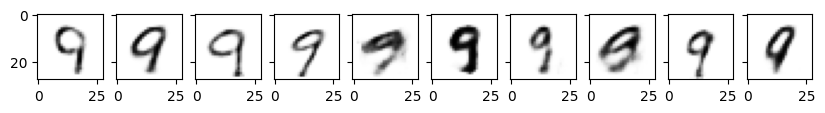

In [90]:
newRandomConditionalImages(trained_cvae_v4)

In [91]:
plot_tsne(trained_cvae_v4, data, kl_version, frac=0.3)

100%|██████████| 469/469 [00:43<00:00, 10.83it/s]


Total Time: 0.72 min
ok load data
start build TSNE


Total Time: 3.20 min


### Train with kl_version 4 and reduction mean

In [97]:
print("Device:", device)
modelCVAE = mcvae.ConditionalVariationalAutoencoder(
              latent_dims= num_latent,
              num_features= num_features,
              num_hidden_layers= num_hidden_1,
              num_classes= num_classes
            )
modelCVAE = modelCVAE.to(device.type)

kl_version = 4
trained_cvae_v4_mean, losses_v4_mean = train2(modelCVAE, data, num_epochs, kl_version, reduction='mean')

Device: cuda:0
Epoch: 001/050 | Batch 000/468 | Cost: 8.2041 | KL v04 ! reduction mean
Epoch: 001/050 | Batch 050/468 | Cost: 0.3397 | KL v04 ! reduction mean
Epoch: 001/050 | Batch 100/468 | Cost: 0.2793 | KL v04 ! reduction mean
Epoch: 001/050 | Batch 150/468 | Cost: 0.2724 | KL v04 ! reduction mean
Epoch: 001/050 | Batch 200/468 | Cost: 0.2414 | KL v04 ! reduction mean
Epoch: 001/050 | Batch 250/468 | Cost: 0.2363 | KL v04 ! reduction mean
Epoch: 001/050 | Batch 300/468 | Cost: 0.2143 | KL v04 ! reduction mean
Epoch: 001/050 | Batch 350/468 | Cost: 0.2298 | KL v04 ! reduction mean
Epoch: 001/050 | Batch 400/468 | Cost: 0.2438 | KL v04 ! reduction mean
Epoch: 001/050 | Batch 450/468 | Cost: 0.2194 | KL v04 ! reduction mean
Time elapsed: 0.21 min
Epoch: 002/050 | Batch 000/468 | Cost: 0.2176 | KL v04 ! reduction mean
Epoch: 002/050 | Batch 050/468 | Cost: 0.2276 | KL v04 ! reduction mean
Epoch: 002/050 | Batch 100/468 | Cost: 0.2206 | KL v04 ! reduction mean
Epoch: 002/050 | Batch 150

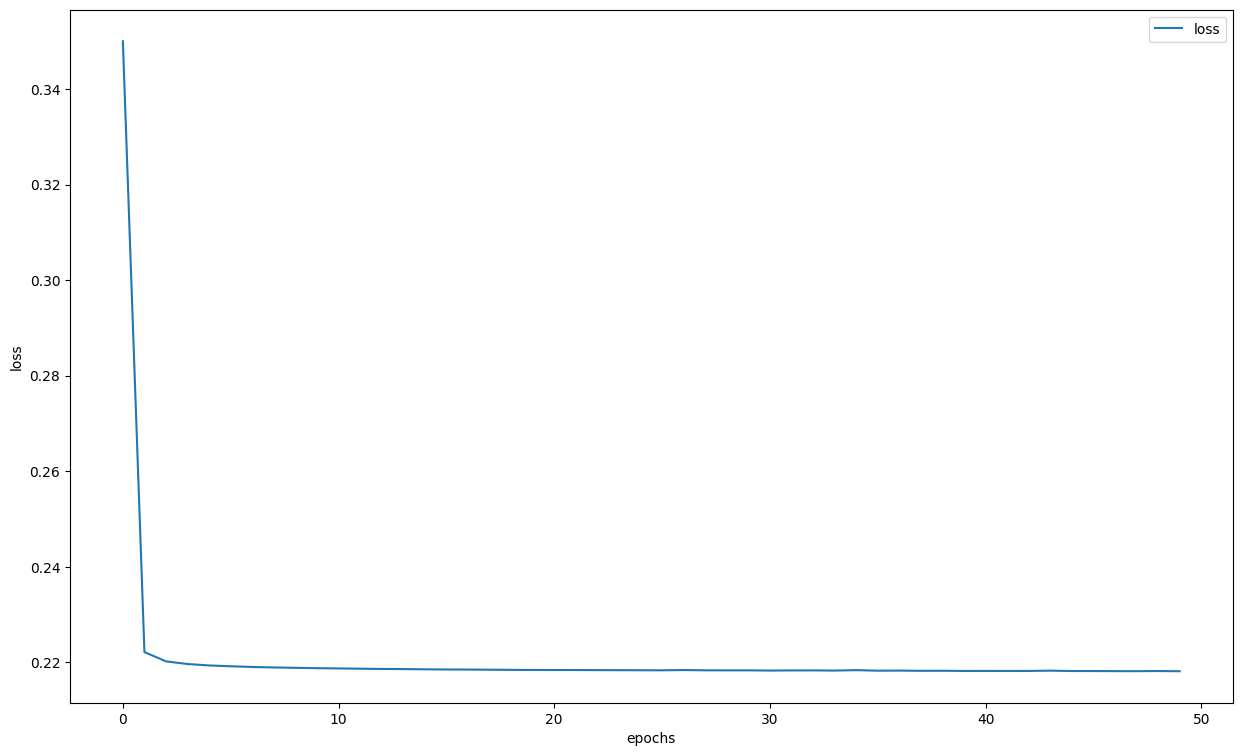

In [99]:
plot_losses(losses_v4_mean)

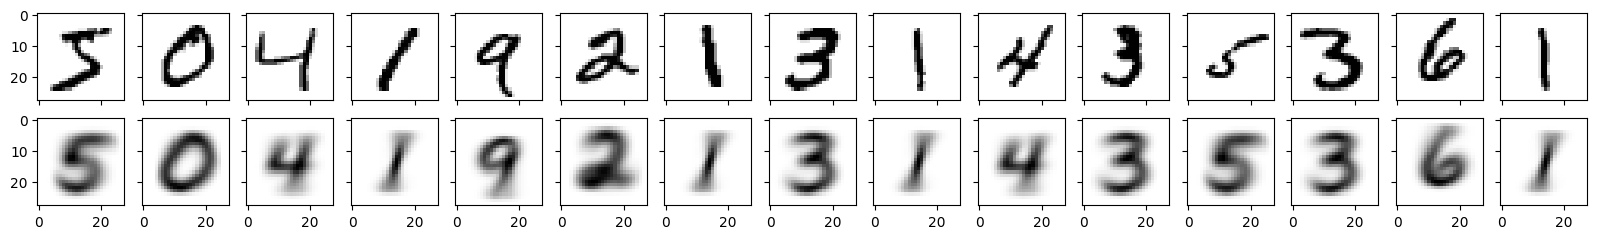

In [100]:
reconstruction(trained_cvae_v4_mean, data, kl_version)

Class Label 0


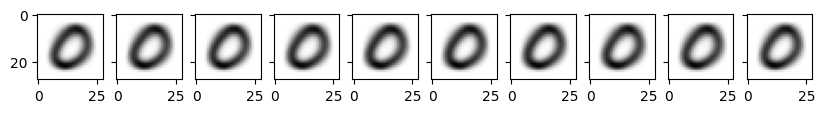

Class Label 1


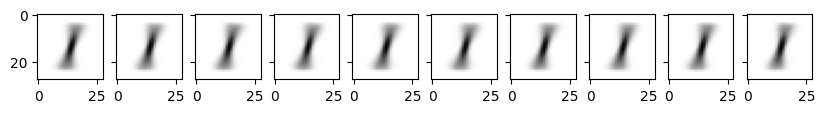

Class Label 2


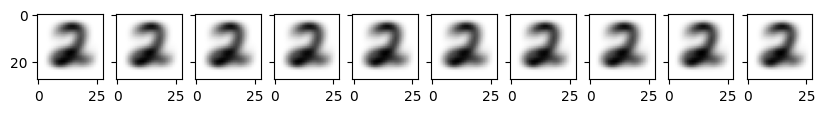

Class Label 3


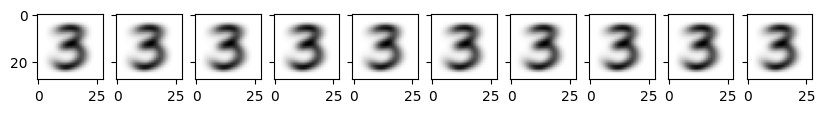

Class Label 4


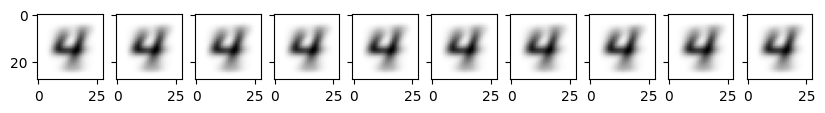

Class Label 5


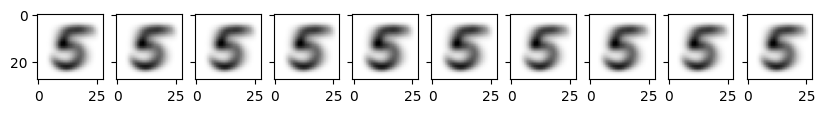

Class Label 6


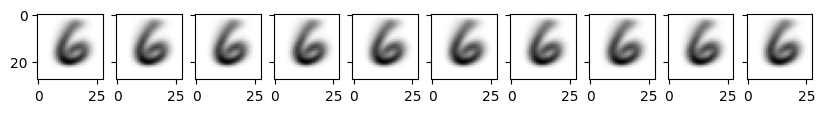

Class Label 7


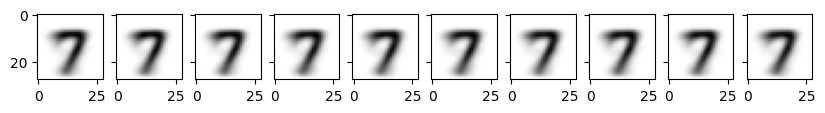

Class Label 8


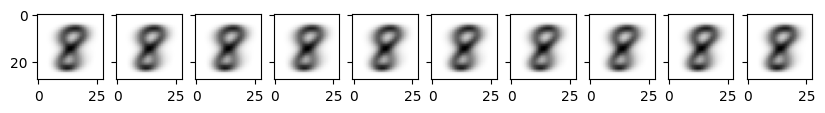

Class Label 9


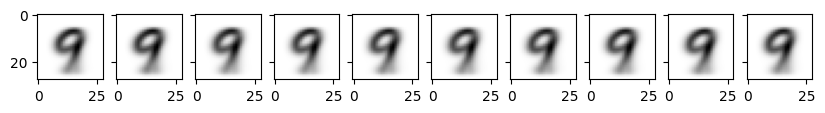

In [102]:
newRandomConditionalImages(trained_cvae_v4_mean)

In [103]:
plot_tsne(trained_cvae_v4_mean, data, kl_version, frac=0.3)

100%|██████████| 469/469 [00:44<00:00, 10.43it/s]


Total Time: 0.75 min
ok load data
start build TSNE


Total Time: 3.00 min
